# ITSM 601 Semester Project
## Austin Animal Shelter Data
### Predicts Adopted/Not Adopted

Travis Lemon and John Bonfardeci
Class of 2018

#### What this notebook does:
* Create randomized K cross-validation (CV) groups
* For-each CV:
    * Split randomized data into (k-1)/k training data and 1/k testing
    * Run LDA K times
        * Find best cutoff (Balanced Accuracy)
        * Output Confusion Matrix, misclassification, and accuracy rates
        * Plot ROC combined with K curves (does not plot cutoff points - these are printed out though)
    
    * Run Logistic Regression K times
        * Find best cutoff (Balanced Accuracy)
        * Output Confusion Matrix, misclassification, and accuracy rates
        * Plot ROC combined with K curves (does not plot cutoff points - these are printed out though)
    
Directions in Jupyter Notebook: Select `Cell -> Run All`. 
Look for printed output and ROC plots at bottom of notebook.

### Global variables

In [1]:
# Change These Parameters

# relative file path; can place in same working directory as notebook
FILE_PATH = 'animal_shelter_train.csv'

# name of target column
TARGET_NAME = 'Adopted'

# Name of Key/ID column
KEY_NAME='AnimalID'

# what value represents the positive value in a binary response: e.g. 1, 'Y', 'T', ...
TARGET_VALUE = 1 

# LDA Solver to use. 
#    Options: 
#        'lsqr' (Least squares solution) - can use with shrikage
#        'svd' (Singular value decomposition) - use with large num features
#        'eigen' (Eigenvalue decomposition) - can use with shrikage
# http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis
LDA_SOLVER = 'lsqr'

# change to None to run LDA without shrinkage
# Options: None, 'auto', float between 0 and 1
# see http://scikit-learn.org/stable/auto_examples/classification/plot_lda.html#sphx-glr-auto-examples-classification-plot-lda-py
LDA_SHRINKAGE = 'auto'

# number of cross-validation groups to run
NUM_CV = 5

# Saving output
SAVE_FIGS = True
OUTPUT_TO_CSV = False
OUTPUT_DIR = ''

# Define global vars
X = None # Matrix of variables
y = None # Dependent variable list
keys = None # Key/ID values
columns = None # Names of variables
df_raw = None # Pandas DataFrame for raw imported data.
df = None # Pandas DataFrame to store our model data.

All of the links below proved helpful in the researh for writing this notebook.
* http://sebastianraschka.com/Articles/2014_python_lda.html#introduction
* http://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis
* https://en.wikipedia.org/wiki/Sensitivity_and_specificity
* https://en.wikipedia.org/wiki/Youden%27s_J_statistic
* http://stats.stackexchange.com/questions/29719/how-to-determine-best-cutoff-point-and-its-confidence-interval-using-roc-curve-i
* https://sasshowcase.wordpress.com/category/sas-macro/
* http://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
* https://www.medcalc.org/manual/roc-curves.php
* http://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/One_ROC_Curve_and_Cutoff_Analysis.pdf
* http://www.umich.edu/~ners580/ners-bioe_481/lectures/pdfs/1978-10-semNucMed_Metz-basicROC.pdf
* http://scikit-learn.org/stable/modules/cross_validation.html
* http://stats.stackexchange.com/questions/95797/how-to-split-the-dataset-for-cross-validation-learning-curve-and-final-evaluat
* http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
* http://gim.unmc.edu/dxtests/roc2.htm
* https://codeyarns.com/2014/10/27/how-to-change-size-of-matplotlib-plot/
* https://en.wikipedia.org/wiki/Receiver_operating_characteristic
* http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix
* http://scikit-learn.org/stable/modules/feature_selection.html

In [2]:
#Import Dependent Libraries
# DON'T change below this line unless you know what your're doing.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import math
import pandas as pd
import numpy as np
from scipy import interp
from itertools import cycle
from copy import copy

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE, SelectFromModel, SelectFpr
from IPython.display import display
import re
import statsmodels.api as sm
import os
import seaborn as sns
from sklearn.naive_bayes import GaussianNB

## OUR OWN CUSTOM STAT MODULE

In [3]:
import StatUtilities as u

# Sample

In [4]:
# Import data and display a summary table.
def import_data(file_path):
    """
    Import a CSV file to a Pandas dataframe.
    @param file_path <string>
    @return Pandas Dataframe
    """
    try:
        if not os.path.exists(file_path):
            print('Invalid file path!')
            return None

        df = pd.read_csv(file_path) # returns new Pandas DataFrame 
        return df
    except IOError:
        print('Error reading file ' + file_path)
        return None

if __name__ == '__main__':
    df_raw = import_data('train.csv')
    df_raw = df_raw.drop('DateTime', 1).drop('OutcomeSubtype', 1).drop('AnimalID', 1).drop('Name', 1)
    display(df_raw.describe())

,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,26729,26728,26711,26729,26729
unique,5,2,5,44,1380,366
top,Adoption,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,10769,15595,9779,3969,8810,2824


# Explore

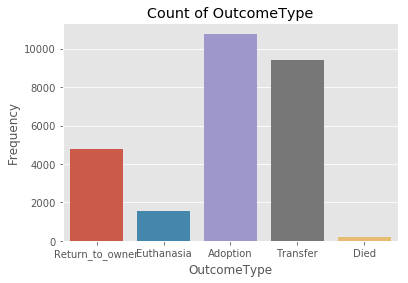

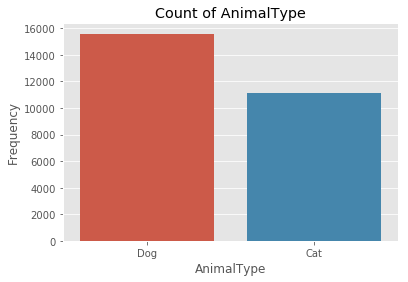

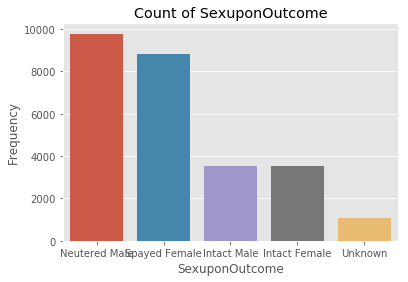

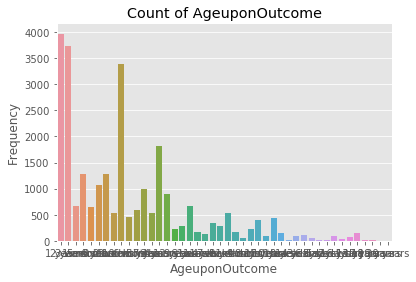

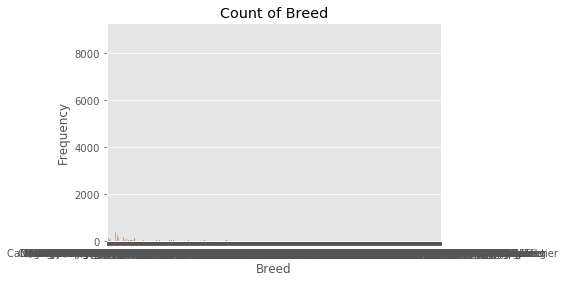

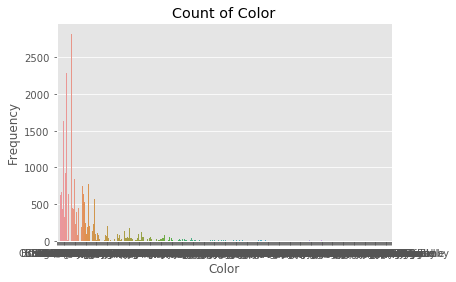

In [26]:
# Create histograms for each variable.
def get_class_plots(df):
    tmp = pd.DataFrame()
    if type(df) != type(tmp):
        print("Parameter 'df' must be of type DataFrame.")
        return
    """
    Display histograms for all the class variables.
    """
    for col in df.columns:
        count, ax = plt.subplots()
        ax = sns.countplot(col, data=df)
        ax.set_title('Count of ' + col)
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        plt.show()

if __name__ == '__main__':
    get_class_plots(df_raw)

# Modify

In [6]:
def transform(dataframe):
    tmp = pd.DataFrame()
    if type(dataframe) != type(tmp):
        print("Parameter 'df' must be of type DataFrame.")
        return
    
    """
    Transform the raw data into usable indicator columns.
    Create new predictors from more concise grouping of categories.
    @param dataframe
    @param target_name
    @returns [y<list>, matrix<list<list>>, dataframe, columns<list>]
    """
    # drop NAs
    dataframe = dataframe.dropna()
    #randomize the data
    dataframe = dataframe.iloc[np.random.permutation(len(dataframe))]
    
    matrix = []
    columns = ['Adopted', 'Cat', 'AgeRange_0', 'AgeRange_1_4', 'AgeRange_5_9', 'AgeRange_10_14', 'AgeRange_15_20',
              'SexuponOutcome', 'ColorCat', 'MixBreed']
    
    for index, row in dataframe.iterrows():
        
        # Adopted
        outcome = 1 if row['OutcomeType'] == 'Adoption' else 0
        
        # Cat or Dog
        cat = 1 if row['AnimalType'] == 'Cat' else 0
        
        # Group ages into age categories.
        age_cat = str(row['AgeuponOutcome'])
        age = int(re.sub('\\D+', '', age_cat))
        ageRange_0 = 0
        ageRange_1_4 = 0
        ageRange_5_9 = 0
        ageRange_10_14 = 0 
        ageRange_15_20 = 0
        
        if age_cat.find('months') > -1:
            ageRange_0 = 1
        else:
            ageRange_1_4 = 1 if age >= 1 and age < 5 else 0
            ageRange_5_9 = 1 if age >= 5 and age < 10 else 0
            ageRange_10_14 = 1 if age >= 10 and age < 15 else 0
            ageRange_15_20 = 1 if age >= 15 else 0
        
        sex = row['SexuponOutcome']
        
        # Combine colors that are similar
        colorCat = None
        color = row['Color']
        
        if color == 'White/Black' or color == 'Black/White':
            colorCat = 'Black/White'
        elif color == 'Tan/Black' or color == 'Black/Tan':
            colorCat = 'Black/Tan'
        elif color == 'Brown/Black' or color == 'Black/Brown':
            colorCat = 'Black/Brown'
        elif color == 'White/Blue' or color == 'Blue/White':
            colorCat = 'Blue/White'
        elif color == 'Brown' or color == 'Chocolate' or color == 'Brown Tabby':
            colorCat = 'Brown'
        elif color == 'White/Brown' or color == 'Brown/White':
            colorCat = 'Brown/White'
        elif color == 'White/Tan' or color == 'Tan':
            colorCat = 'Tan'
        elif color == 'Yellow/White' or color.rfind('Yellow') == 0:
            colorCat = 'Yellow'
        elif color.find('White') == 0:
            colorCat = 'White'
        elif color.find('Blue') == 0:
            colorCat = 'Blue'
        elif color.find('Black') == 0:
            colorCat = 'Black'
        elif color.find('Tricolor') == 0:
            colorCat = 'Tricolor'
        elif color.find('Tortie') == 0:
            colorCat = 'Tortie'
        elif color == 'Calico':
            colorCat = 'Calico'
        elif color.find('Red') == 0:
            colroCat = 'Red'
        else:
            colorCat = 'Other'
        
        breed = row['Breed']
        
        # Mix
        mixedBreed = 1 if row['Breed'].lower().find('mix') > -1 else 0

        a = [outcome, cat, ageRange_0, ageRange_1_4, ageRange_5_9, ageRange_10_14, ageRange_15_20, 
             sex, colorCat, mixedBreed]
        
        matrix.append(a)
    # /end for...
        
    df = pd.DataFrame(data=matrix, columns=columns) # Create dataframe
    df = pd.get_dummies(df)
    
    # Clean col names removing special characters
    df.columns = map(lambda c: re.sub('[^a-zA-Z0-9_]', '_', c), df.columns)
    
    # Get list of actual Y outcomes
    y = pd.Series( map(lambda x: 1 if x == 1 else 0, df['Adopted']) ).as_matrix()
    df = df.drop('Adopted', 1) # can't include Y as predictor, drop
    X = df.as_matrix() # Get predictors only
    return [y, X, df, df.columns]
    
if __name__ == '__main__':
    y, X, df, columns = transform(dataframe=df_raw)
    display(df.describe())

,Cat,AgeRange_0,AgeRange_1_4,AgeRange_5_9,AgeRange_10_14,AgeRange_15_20,MixBreed,SexuponOutcome_Intact_Female,SexuponOutcome_Intact_Male,SexuponOutcome_Neutered_Male,...,ColorCat_Blue_White,ColorCat_Brown,ColorCat_Brown_White,ColorCat_Calico,ColorCat_Other,ColorCat_Tan,ColorCat_Tortie,ColorCat_Tricolor,ColorCat_White,ColorCat_Yellow
count,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,...,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000
mean,0.416211,0.312205,0.525983,0.116099,0.039161,0.005728,0.834145,0.131187,0.131748,0.366118,...,0.031187,0.090116,0.054399,0.019356,0.265219,0.038076,0.022950,0.029951,0.060314,0.009734
std,0.492939,0.463402,0.499334,0.320349,0.193982,0.075469,0.371958,0.337611,0.338223,0.481751,...,0.173826,0.286353,0.226808,0.137776,0.441458,0.191382,0.149748,0.170456,0.238073,0.098182
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Model & Assess

## Variable Selection

In [7]:
# Lasso feature selection
def get_lasso_selection(X, y, columns):
    """
    Select significant variables according to Lasso.
    Best model is selected by cross-validation.
    @param X <Pandas Dataframe>
    @param y <list>
    @columns <list>
    @returns <list>
    """
    clf = LassoCV(max_iter=10000)
    sfm = SelectFromModel(clf)
    sfm.fit(X, y)
    features = sfm.transform(X).shape[1]
    feature_indices = sfm.get_support()
    significant_features = []
    for c, b in zip(columns, feature_indices):
        if b:
            significant_features.append(c)
            
    return significant_features
   
def select_fpr(X, y, columns):
    s_fpr = SelectFpr() 
    fit = s_fpr.fit(X, y)
    pvalue_data = []
    pvalues = fit.pvalues_
    for (col, val) in zip(columns, pvalues):
        pvalue_data.append((col, round(float(val), 6)))

    df_pvalues = pd.DataFrame(data=pvalue_data, columns=['X', 'pvalue']).sort_values(by='pvalue', ascending=True)
    display(df_pvalues)
    return df_pvalues['X'].as_matrix()
    
def remove_insignificant_vars(sig_var_list, df):
    """
    Remove insignificant variables from a DataFrame.
    @param sig_var_list <list>
    @param df <DataFrame>
    @returns <DataFrame>
    """
    drop = []
    cols = df.columns.tolist()
    for v in cols:
        if not v in sig_var_list:
            drop.append(v)
            df = df.drop(str(v), 1)
            
       
    print('\r\nDropped insignificant vars: ', ', '.join(drop))
    display(df.describe())
    return df
    
if __name__ == '__main__':
    significant_features = get_lasso_selection(X=X, y=y, columns=columns)
    #significant_features = select_fpr(X, y, columns)
    print('Selected significant variables are:\r\n', ', '.join(significant_features))

    df = remove_insignificant_vars(significant_features, df.copy())
    X = df.as_matrix() 
    columns = df.columns.tolist()

Selected significant variables are:
 Cat, AgeRange_0, AgeRange_1_4, AgeRange_10_14, AgeRange_15_20, MixBreed, SexuponOutcome_Intact_Male, SexuponOutcome_Neutered_Male, SexuponOutcome_Spayed_Female, SexuponOutcome_Unknown, ColorCat_Black, ColorCat_Black_Brown, ColorCat_Black_Tan, ColorCat_Blue, ColorCat_Brown_White, ColorCat_Other, ColorCat_Tortie, ColorCat_Tricolor, ColorCat_White, ColorCat_Yellow

Dropped insignificant vars:  AgeRange_5_9, SexuponOutcome_Intact_Female, ColorCat_Black_White, ColorCat_Blue_White, ColorCat_Brown, ColorCat_Calico, ColorCat_Tan


,Cat,AgeRange_0,AgeRange_1_4,AgeRange_10_14,AgeRange_15_20,MixBreed,SexuponOutcome_Intact_Male,SexuponOutcome_Neutered_Male,SexuponOutcome_Spayed_Female,SexuponOutcome_Unknown,ColorCat_Black,ColorCat_Black_Brown,ColorCat_Black_Tan,ColorCat_Blue,ColorCat_Brown_White,ColorCat_Other,ColorCat_Tortie,ColorCat_Tricolor,ColorCat_White,ColorCat_Yellow
count,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000,26710.000000
mean,0.416211,0.312205,0.525983,0.039161,0.005728,0.834145,0.131748,0.366118,0.330176,0.040771,0.101423,0.028791,0.032010,0.054062,0.054399,0.265219,0.022950,0.029951,0.060314,0.009734
std,0.492939,0.463402,0.499334,0.193982,0.075469,0.371958,0.338223,0.481751,0.470285,0.197764,0.301893,0.167221,0.176031,0.226145,0.226808,0.441458,0.149748,0.170456,0.238073,0.098182
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
def get_var_estimates(target_name, y, X, columns):
    """
    Show OLS parameter estimates for the model.
    Ref: http://statsmodels.sourceforge.net/devel/generated/statsmodels.regression.linear_model.RegressionResults.html
    http://statsmodels.sourceforge.net/devel/examples/generated/example_ols.html
    @param target_name <string>
    @param y <list>
    @param X <Pandas Dataframe>
    @param columns <list>
    @returns Statsmodel summary
    """
    model = sm.OLS(y, X)
    results = model.fit()
    return results.summary(yname=target_name, xname=columns, title='PValues', alpha=0.05)
    
if __name__ == '__main__':
    summary = get_var_estimates(target_name=TARGET_NAME, y=y, X=X, columns=[c for c in columns])
    #display(summary)
    #print(dir(summary))
    display(summary.tables[1])
    # output estimates to CSV
    outfile = open('estimates.csv', 'w')
    outfile.write(summary.tables[1].as_csv())
    outfile.close()

,coef,std err,t,P>|t|,[0.025,0.975]
Cat,0.0431,0.006,6.967,0.000,0.031,0.055
AgeRange_0,0.3184,0.008,41.956,0.000,0.304,0.333
AgeRange_1_4,0.0755,0.007,11.288,0.000,0.062,0.089
AgeRange_10_14,-0.1017,0.014,-7.371,0.000,-0.129,-0.075
AgeRange_15_20,-0.1825,0.033,-5.486,0.000,-0.248,-0.117
MixBreed,-0.0513,0.006,-8.109,0.000,-0.064,-0.039
SexuponOutcome_Intact_Male,-0.0534,0.009,-6.008,0.000,-0.071,-0.036
SexuponOutcome_Neutered_Male,0.4296,0.007,63.301,0.000,0.416,0.443
SexuponOutcome_Spayed_Female,0.4804,0.007,69.842,0.000,0.467,0.494
SexuponOutcome_Unknown,-0.0850,0.014,-6.139,0.000,-0.112,-0.058


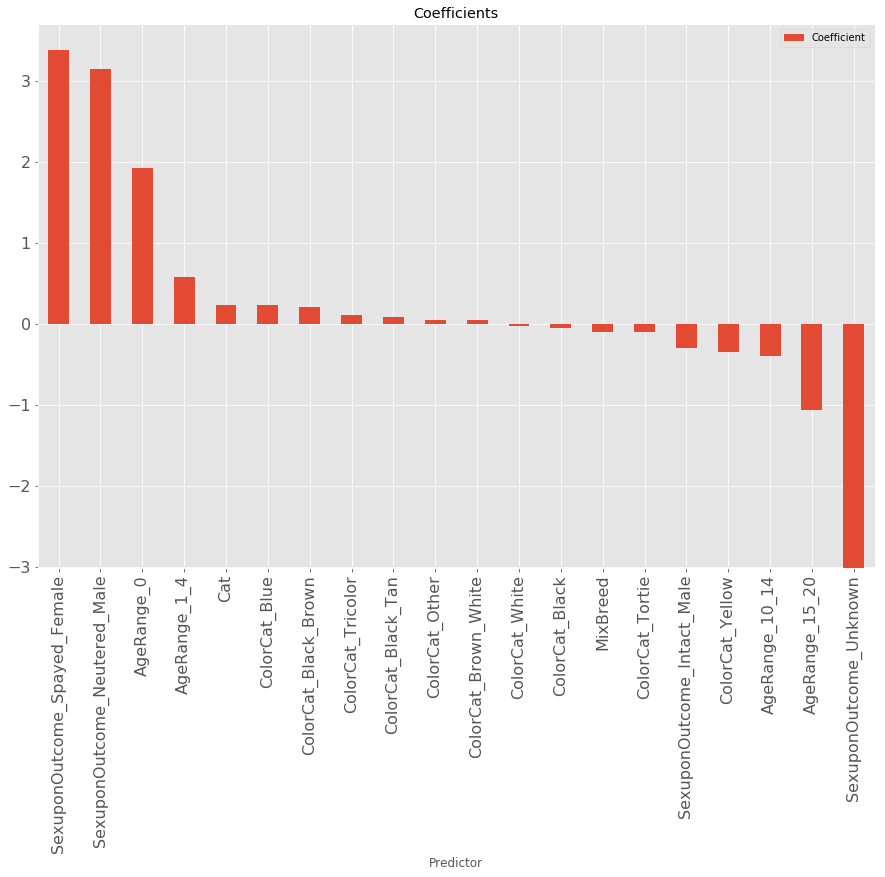

,Predictor,Coefficient
8,SexuponOutcome_Spayed_Female,3.383647
7,SexuponOutcome_Neutered_Male,3.150890
1,AgeRange_0,1.921576
2,AgeRange_1_4,0.580470
0,Cat,0.242290
13,ColorCat_Blue,0.238830
11,ColorCat_Black_Brown,0.208737
17,ColorCat_Tricolor,0.107952
12,ColorCat_Black_Tan,0.091824
15,ColorCat_Other,0.054612


In [17]:
def display_coeff(columns, X, y):
    """
    Display estimated coefficients as bar chart and table.
    @returns void
    """
    logit = LogisticRegression()
    logit.fit(X, y)

    est_col = []
    for col, coef in zip(df.columns, logit.coef_[0]):
        est_col.append([col, coef])

    df_est = pd.DataFrame(data=est_col, columns=['Predictor', 'Coefficient'])
    df_est = df_est.sort_values('Coefficient', ascending=False)

    # plot
    df_est.plot.bar(x=df_est["Predictor"], figsize=(15, 10), fontsize=16, title ='Coefficients')
    plt.show()
    display(df_est)
    
    
if __name__ == '__main__':
    display_coeff(df.columns.tolist(), X, y)

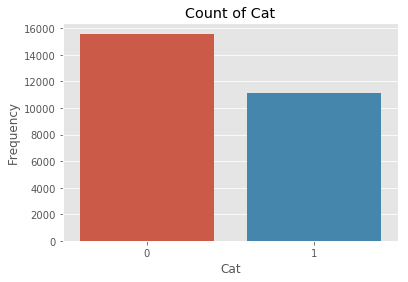

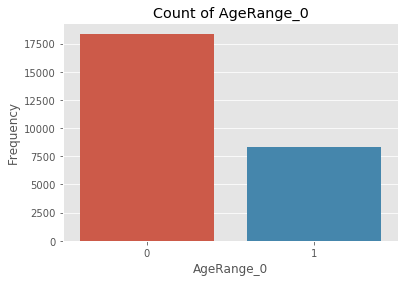

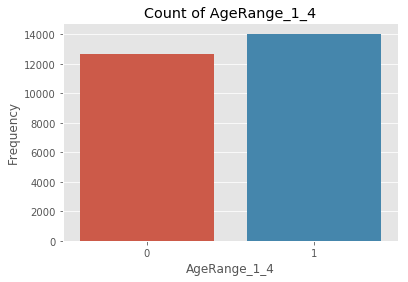

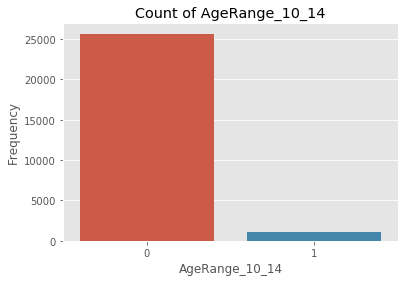

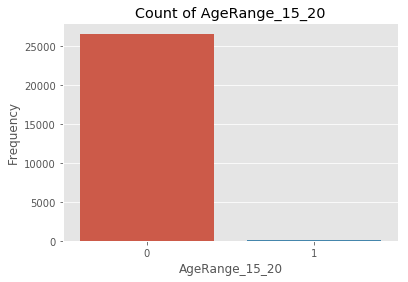

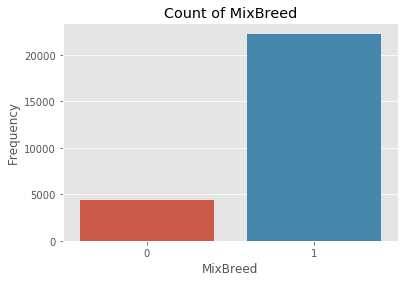

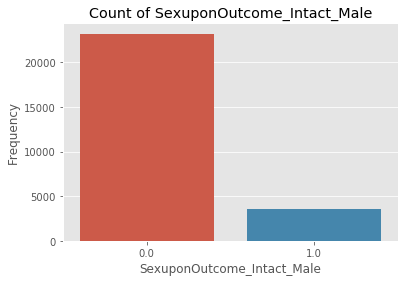

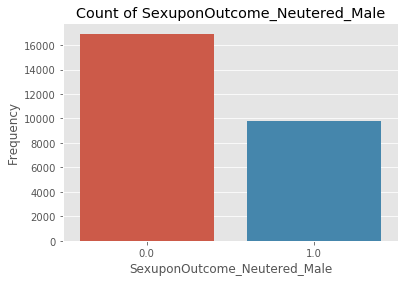

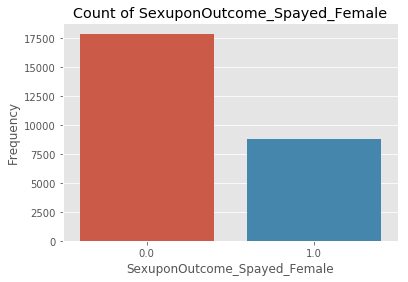

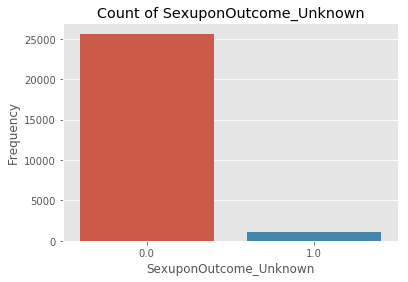

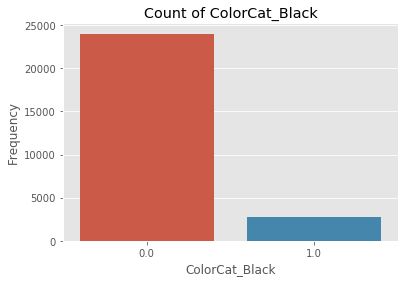

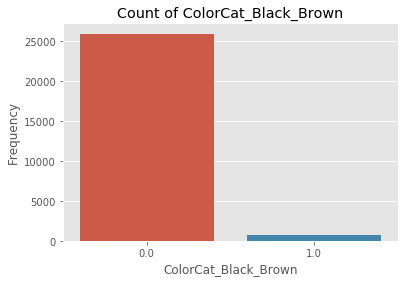

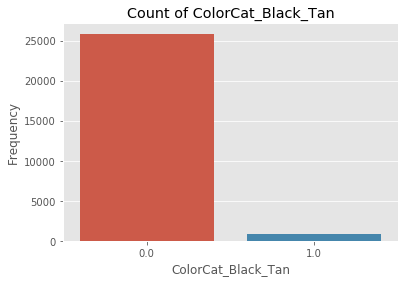

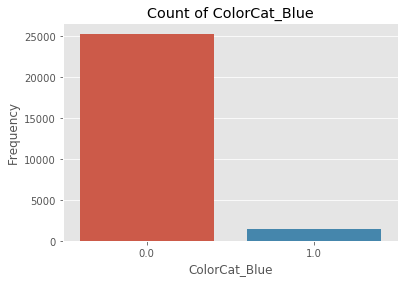

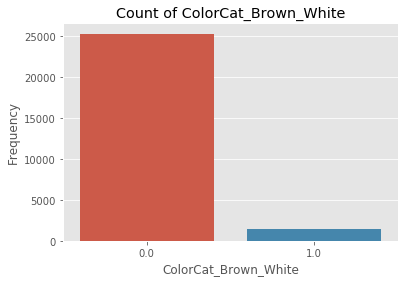

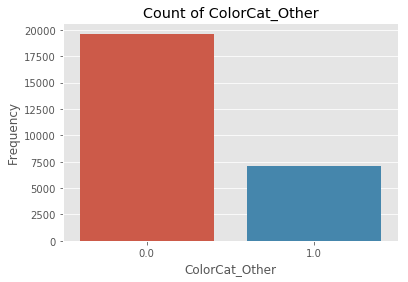

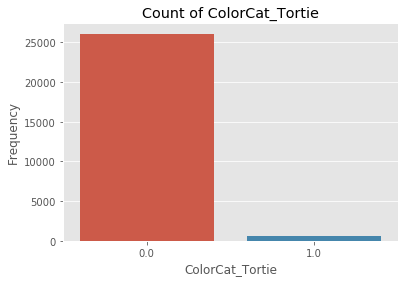

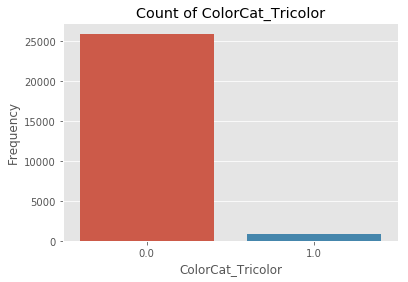

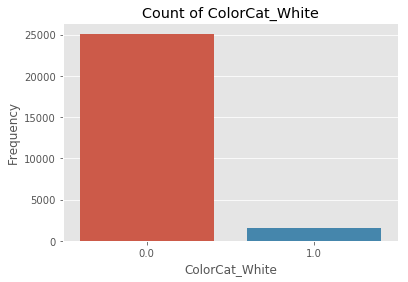

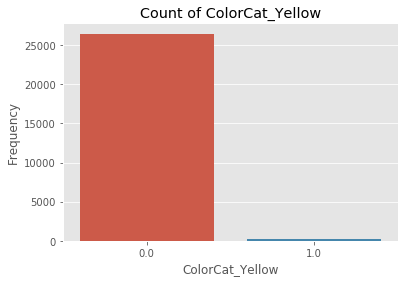

In [10]:
get_class_plots(df)

Fold 1, TPR: 0.86305, TNR: 0.65036, Cutoff: 0.42000
Fold 2, TPR: 0.87790, TNR: 0.60979, Cutoff: 0.36000
Fold 3, TPR: 0.90344, TNR: 0.61292, Cutoff: 0.34000
Fold 4, TPR: 0.86722, TNR: 0.62484, Cutoff: 0.39000
Fold 5, TPR: 0.87784, TNR: 0.62359, Cutoff: 0.40000
Means:  TPR: 0.87789, TNR: 0.62430, Cutoff: 0.38200
ROC image was saved to: lda-roc.png


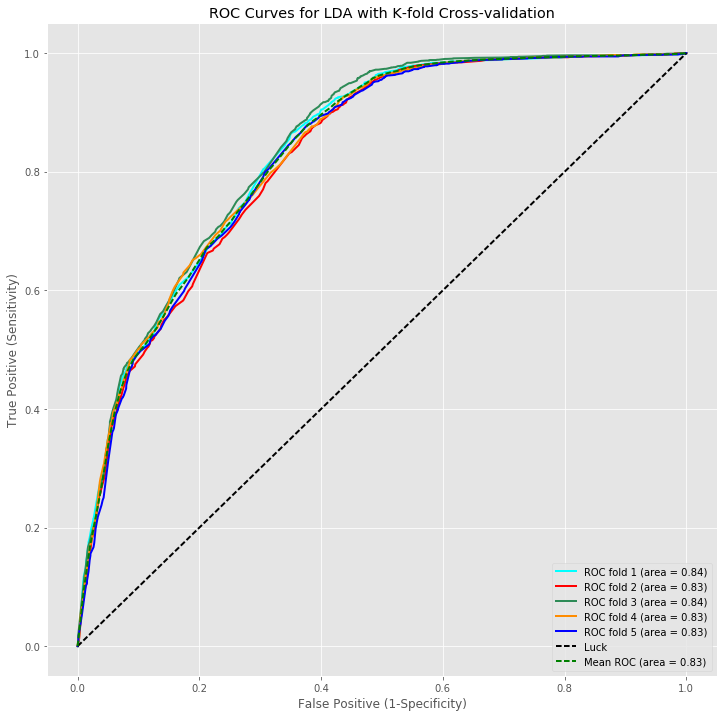

Confusion matrix image was saved to: lda-best-tp-cm.png


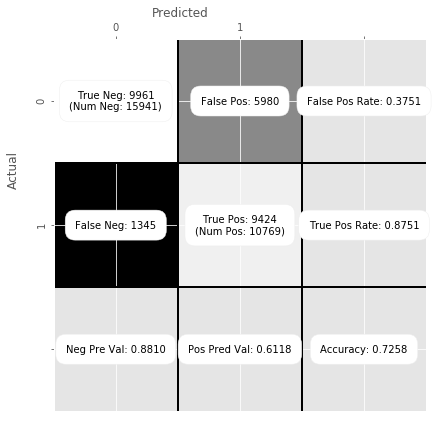

In [11]:
# Run LDA with cross-validation and plot ROC curves
def fit_lda():
    """
    Fit a model with Linear Discriminant Analysis (LDA).
    """
    # Estimate priors.
    gnb = GaussianNB()
    gnb.fit(X, y)
    priors = gnb.class_prior_

    rand = np.random.RandomState(0)
    cv = StratifiedKFold(n_splits=NUM_CV, shuffle=True, random_state=rand)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
    roc_kfolds = []
    cm_folds = []
    lda_actual = []
    lda_prob = []
    best_mean_cutoff = 0.0
    best_mean_tpr = 0.0
    best_mean_fpr = 0.0

    # For each cross-validation batch, fit model 80:20 split, plot ROC, and get cutoff
    # train, test are of type <type 'numpy.ndarray'>
    i = 0
    for (train, test) in cv.split(X, y):

        test_actual = y[test]
        test_X = X[test]
        train_X = X[train]
        train_y = y[train]

        # train LDA on training dataset
        lda = LinearDiscriminantAnalysis(solver=LDA_SOLVER, priors=priors, 
                                         shrinkage=LDA_SHRINKAGE, store_covariance=True).fit(train_X, train_y)
        # test LDA on test dataset
        # predict probability returns <type 'numpy.ndarray'> (n_samples, n_classes)
        prob = lda.predict_proba(test_X)

        # get predicted values: 1/0; default threshold/cutoff is 0.5
        predicted = lda.predict(test_X)
        train_predicted = lda.predict(train_X)

        # Compute ROC curve
        # fpr = false positive rate (1-specificity)
        # tpr = true positive rate (sensitivity)
        fpr, tpr, thresholds = roc_curve(test_actual, prob[:, 1]) # returns <type 'numpy.ndarray'> x 3

        # add mean Sensitivity
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        lda_actual.extend(test_actual)
        lda_prob.extend(prob)
        roc_kfolds.append([tpr, fpr])
        best_tpr, best_fpr, best_cutoff = u.Utilities.get_best_cutoff(actual=test_actual, prob=prob)
        best_mean_cutoff += best_cutoff
        best_mean_tpr += best_tpr
        best_mean_fpr += best_fpr
        
        print('Fold %d, TPR: %0.5f, TNR: %0.5f, Cutoff: %0.5f' % (i+1, best_tpr, 1-best_fpr, best_cutoff))

        i += 1
        #/for (train, test)...

    best_mean_tpr /= float(NUM_CV)
    best_mean_fpr /= float(NUM_CV)
    best_mean_cutoff /= float(NUM_CV)
    print('Means:  TPR: %0.5f, TNR: %0.5f, Cutoff: %0.5f'%(best_mean_tpr, 1-best_mean_fpr, best_mean_cutoff))

    # Display ROC Curve, output to CSV
    u.Utilities.show_roc(roc_kfolds, mean_tpr, mean_fpr, 'ROC Curves for LDA with K-fold Cross-validation', 2, 'lda-roc')

    if OUTPUT_TO_CSV:
        u.Utilities.output_cms('lda-cms', cm_folds, 'LDA_Test_Folds') # output to CSV

    # Display Confustion Matrix, output to PNG
    best_tp = u.Utilities.get_confusion_matrix(best_mean_cutoff, lda_actual, lda_prob)
    
    # Display Confustion Matrix, output to PNG
    u.Utilities.show_confusion_matrix(best_tp, ['0','1'], (6,6), 12, 'lda-best-tp-cm')
    
    
if __name__ == '__main__':
    fit_lda()

Fold 1, TPR: 0.87512, TNR: 0.63719, Cutoff: 0.42000
Fold 2, TPR: 0.85422, TNR: 0.63363, Cutoff: 0.41000
Fold 3, TPR: 0.90390, TNR: 0.61198, Cutoff: 0.35000
Fold 4, TPR: 0.86955, TNR: 0.62327, Cutoff: 0.39000
Fold 5, TPR: 0.87552, TNR: 0.62578, Cutoff: 0.40000
Means:  TPR: 0.87566, TNR: 0.62637, Cutoff: 0.39400
ROC image was saved to: logit-roc.png


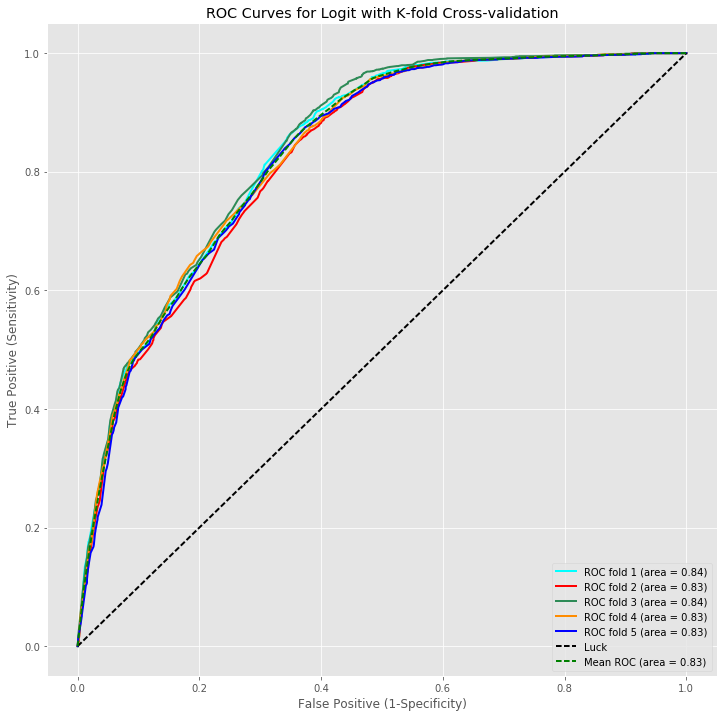

Confusion matrix image was saved to: logit-best-tp-cm.png


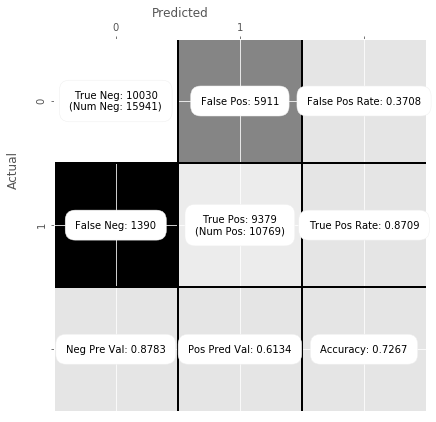

,Cat,AgeRange_0,AgeRange_1_4,AgeRange_10_14,AgeRange_15_20,MixBreed,SexuponOutcome_Intact_Male,SexuponOutcome_Neutered_Male,SexuponOutcome_Spayed_Female,SexuponOutcome_Unknown,...,ColorCat_Brown_White,ColorCat_Other,ColorCat_Tortie,ColorCat_Tricolor,ColorCat_White,ColorCat_Yellow,Adopted,Prob_0,Prob_1,Predicted
26705,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0.534403,0.465597,0
26706,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.581793,0.418207,0
26707,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0.165748,0.834252,1
26708,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.500788,0.499212,0
26709,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0.534403,0.465597,0


In [12]:
# Run logistic Regression with cross-validation and plot ROC curves
# Logit can use categorical variaables. Append to cols and get new data set
def fit_logit():
    """
    Fit a model with Logistic Regression.
    """
    rand = np.random.RandomState(0)
    cv = StratifiedKFold(n_splits=NUM_CV, shuffle=True, random_state=rand) # split into N folds
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100) # `linspace` returns evenly spaced numbers over a specified interval.
    roc_kfolds = [] # store TPR and FPR for each iteration and plot to ROC curve
    cm_folds = []
    logit_actual = []
    logit_prob = []
    best_mean_cutoff = 0.0
    best_mean_tpr = 0.0
    best_mean_fpr = 0.0
    predicted_data = []

    # For each cross-validation batch, fit model 80:20 split, plot ROC, and get cutoff
    # train, test are of type <type 'numpy.ndarray'>
    i = 0
    for (train, test) in cv.split(X, y):

        test_actual = y[test]
        test_X = X[test]
        train_X = X[train]
        train_y = y[train]

        # train Logit on training dataset
        logit = LogisticRegression()
        logit.fit(train_X, train_y)

        # test Logit on test dataset
        # predict probability returns <type 'numpy.ndarray'> (n_samples, n_classes)
        prob = logit.predict_proba(test_X)

        # get predicted values: 1/0; default threshold/cutoff is 0.5
        predicted = logit.predict(test_X)
        train_predicted = logit.predict(train_X)

        # Compute ROC curve
        # fpr = false positive rate (1-specificity)
        # tpr = true positive rate (sensitivity)
        fpr, tpr, thresholds = roc_curve(test_actual, prob[:, 1]) # returns <type 'numpy.ndarray'> x 3
        
        # add mean Sensitivity
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        logit_actual.extend(test_actual)
        logit_prob.extend(prob)
        
        best_tpr, best_fpr, best_cutoff = u.Utilities.get_best_cutoff(actual=test_actual, prob=prob)
        
        roc_kfolds.append([tpr, fpr])
        
        best_mean_cutoff += best_cutoff
        best_mean_tpr += best_tpr
        best_mean_fpr += best_fpr
        
        print('Fold %d, TPR: %0.5f, TNR: %0.5f, Cutoff: %0.5f' % (i+1, best_tpr, 1-best_fpr, best_cutoff))
    
        # Collect test set into combined table
        predicted_data.extend(u.Utilities.combine(prob, test_X, test_actual, predicted))
        
        i += 1
    #/for (train, test)...

    best_mean_tpr /= float(NUM_CV)
    best_mean_fpr /= float(NUM_CV)
    best_mean_cutoff /= float(NUM_CV)
    print('Means:  TPR: %0.5f, TNR: %0.5f, Cutoff: %0.5f'%(best_mean_tpr, 1-best_mean_fpr, best_mean_cutoff))

    # Display ROC Curve, output to CSV
    u.Utilities.show_roc(roc_kfolds, mean_tpr, mean_fpr, 'ROC Curves for Logit with K-fold Cross-validation', 2, 'logit-roc')

    if OUTPUT_TO_CSV:
        u.Utilities.output_cms('logit-cms', cm_folds, 'Logit_Test_Folds') # output to excel

    # Display Confustion Matrix, output to PNG
    best_tp = u.Utilities.get_confusion_matrix(best_mean_cutoff, logit_actual, logit_prob)
    u.Utilities.show_confusion_matrix(best_tp, ['0','1'], (6,6), 12, 'logit-best-tp-cm')
    
    # Output final dataset with predictions to CSV  
    col_names = np.append(np.asarray(significant_features), np.asarray([TARGET_NAME, 'Prob_0', 'Prob_1', 'Predicted']))
    df = pd.DataFrame(data=predicted_data, columns=col_names)
    df.to_csv(OUTPUT_DIR + 'validation.csv')
    display(df.tail())
    
if __name__ == '__main__':
    fit_logit()